In [3]:
import pandas as pd
import numpy as np
import requests

from numpy import mean
from numpy import std

import warnings
warnings.filterwarnings("ignore")
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [1]:
##Access Target_device data
QuerytoolBASE = "http://127.0.0.1:5000/"
response = requests.get(QuerytoolBASE+"databaseservice",json={"autoscaler": "1998-05-02"})
data_result = response.json()


NameError: name 'requests' is not defined

In [6]:
QuerytoolBASE = "http://127.0.0.1:5000/"
response = requests.get(QuerytoolBASE+"databaseservice",json={"start_date": "1998-05-01 01:00:00", "databasename": "worldcup98", "end_date": "1998-07-20 00:00:00"})
data_result = response.json()


                     total_load
timestamp                      
1998-05-01 01:00:00           5
1998-05-01 01:00:01           9
1998-05-01 01:00:02           2
1998-05-01 01:00:03          14
1998-05-01 01:00:04          14


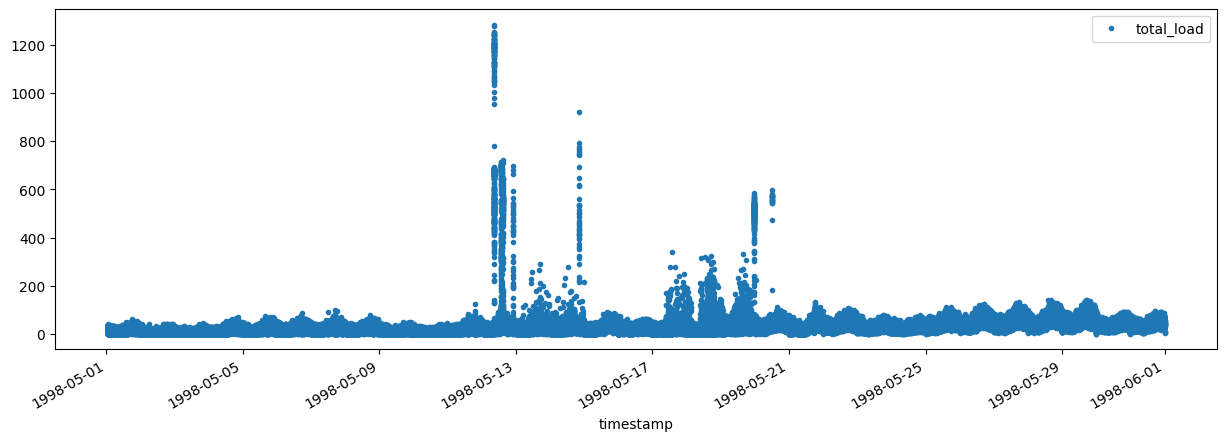

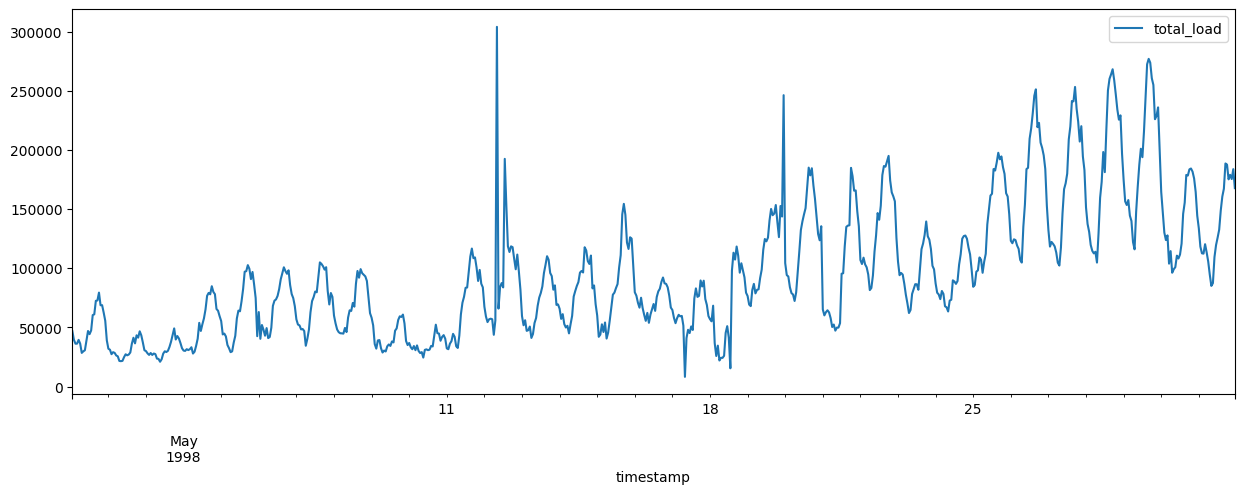

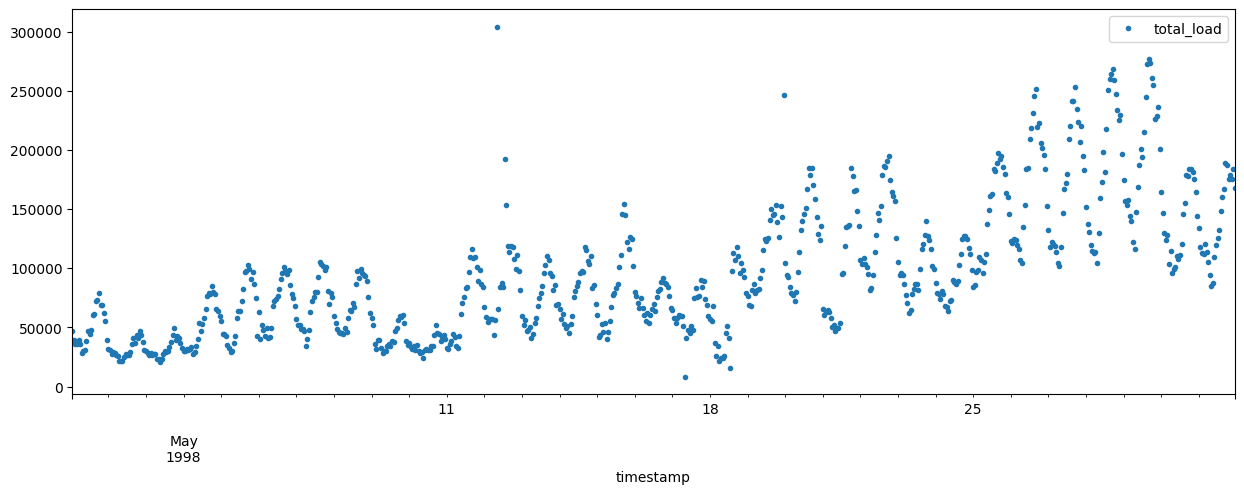

In [7]:
historical_df = pd.DataFrame(data_result, columns=['timestamp', 'requests'])
historical_df['timestamp'] = pd.to_datetime(historical_df['timestamp'], infer_datetime_format=True, errors='coerce') 
#historical_df = historical_df.dropna(subset=['timestamp'])
#print(historical_df.head)
historical_df = historical_df.set_index("timestamp")
historical_df['total_load'] = historical_df['requests'].astype(int)
#historical_df = historical_df[historical_df['total_load'] < 5000]
historical_df = historical_df.drop(columns=['requests'])

historical_df.plot(style=".", figsize=(15, 5))
#print( historical_df.head())
hourly_sum = historical_df.resample('H').sum()
hourly_sum.plot(figsize=(15, 5))

df = hourly_sum
df.plot(style=".", figsize=(15, 5))
print(historical_df.head())

<Axes: xlabel='timestamp'>

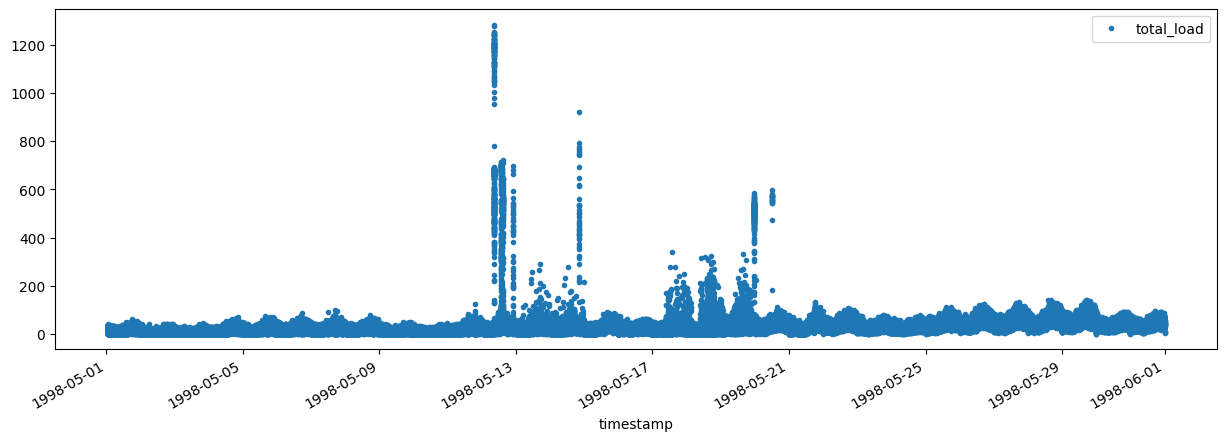

In [8]:
historical_df.plot(style=".", figsize=(15, 5))


                     total_load
timestamp                      
1998-05-02 00:00:00       31969
1998-05-02 01:00:00       31132
1998-05-02 02:00:00       27349
1998-05-02 03:00:00       29052
1998-05-02 04:00:00       28462


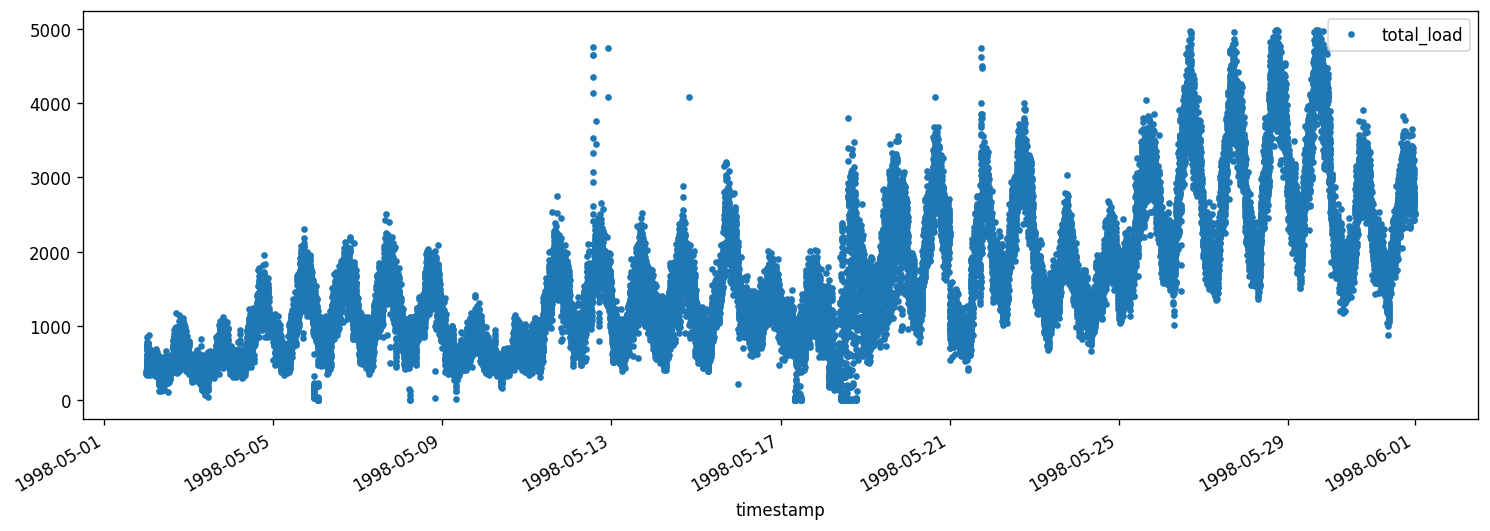

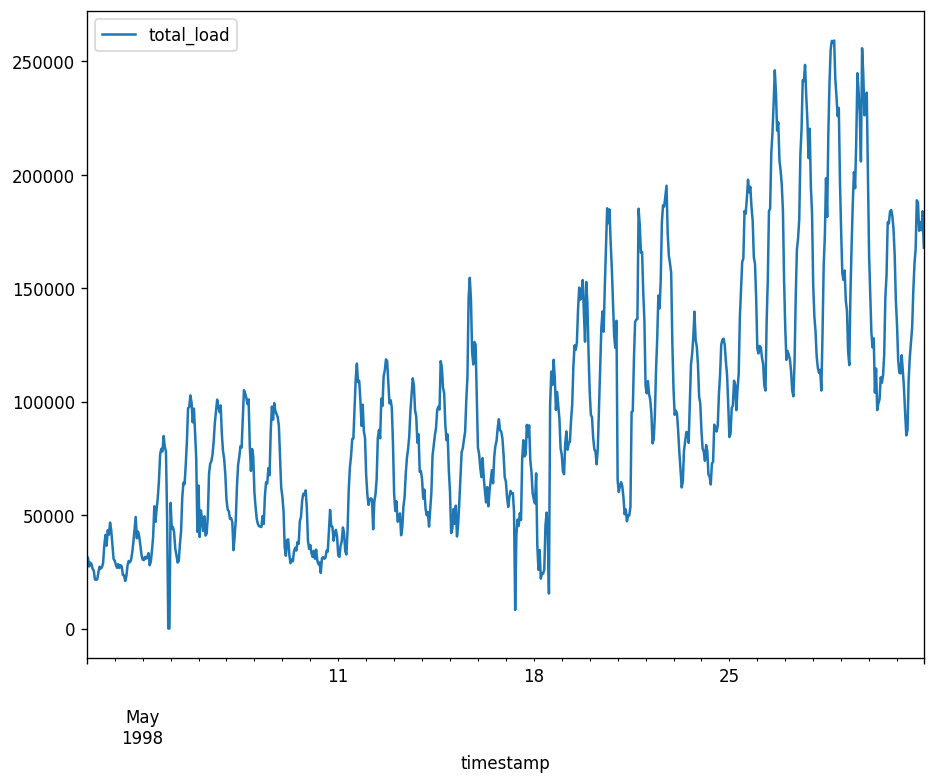

In [144]:
historical_df = pd.DataFrame(data_result, columns=['timestamp', 'average_load', 'total_load', 'instances'])
historical_df['timestamp'] = pd.to_datetime(historical_df['timestamp'], infer_datetime_format=True, errors='coerce') 
historical_df = historical_df.dropna(subset=['timestamp'])
historical_df = historical_df.set_index("timestamp")
historical_df['total_load'] = historical_df['total_load'].astype(int)
historical_df = historical_df[historical_df['total_load'] < 5000]
historical_df = historical_df.drop(columns=['average_load', 'instances'])

historical_df.plot(style=".", figsize=(15, 5))
#print( historical_df.head())
hourly_sum = historical_df.resample('H').sum()
#hourly_sum.plot(figsize=(15, 5))

df = hourly_sum
df.plot()
print(df.head())

Adfuller and critical values


In [7]:

msk = df.index < (df.index[-1] - pd.Timedelta(hours=180)) #hårdkodat, ändra!

# dubbelkolla mask values
#print(msk)
print(df.head())

# splitta dataframe
df_train = df[msk].copy()
df_test = df[~msk].copy()
#print(df_train)
#print(df_test)

# Plot the training and test sets
#df_train.plot(style=".", figsize=(15, 5), label='Train')
#df_test.plot(style=".", figsize=(15, 5), label='Test')


result = adfuller(df['total_load'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1]) # if p-value is > 0.05 --> differenciate again!!!
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))


                     total_load
timestamp                      
1995-07-01 01:00:00        2978
1995-07-01 02:00:00        2246
1995-07-01 03:00:00        1713
1995-07-01 04:00:00        1468
1995-07-01 05:00:00        1323
ADF Statistic: -2.797812
p-value: 0.058587
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570


Differencing

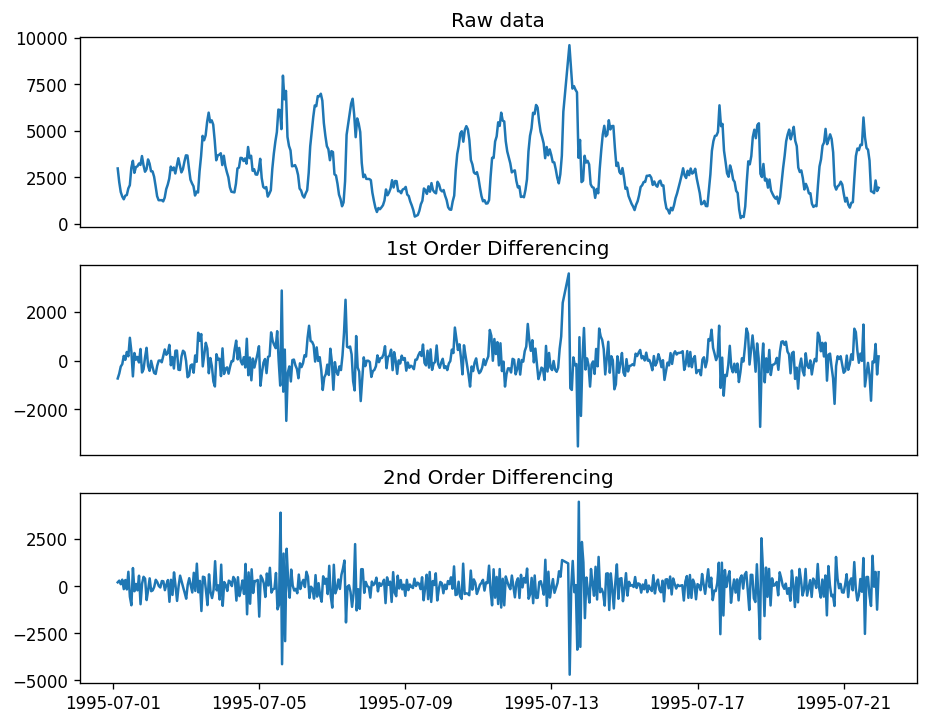

In [9]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

df = df[df['total_load'] < 10000]
 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(df); ax1.set_title('Raw data'); ax1.axes.xaxis.set_visible(False)
# FÖRSTA Differencing
ax2.plot(df.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# ANDRA Differencing
ax3.plot(df.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

# Titta på vart kurvan stationeras, samt vilken som har minst noice. Detta blir d-värdet!!!


ACF plot

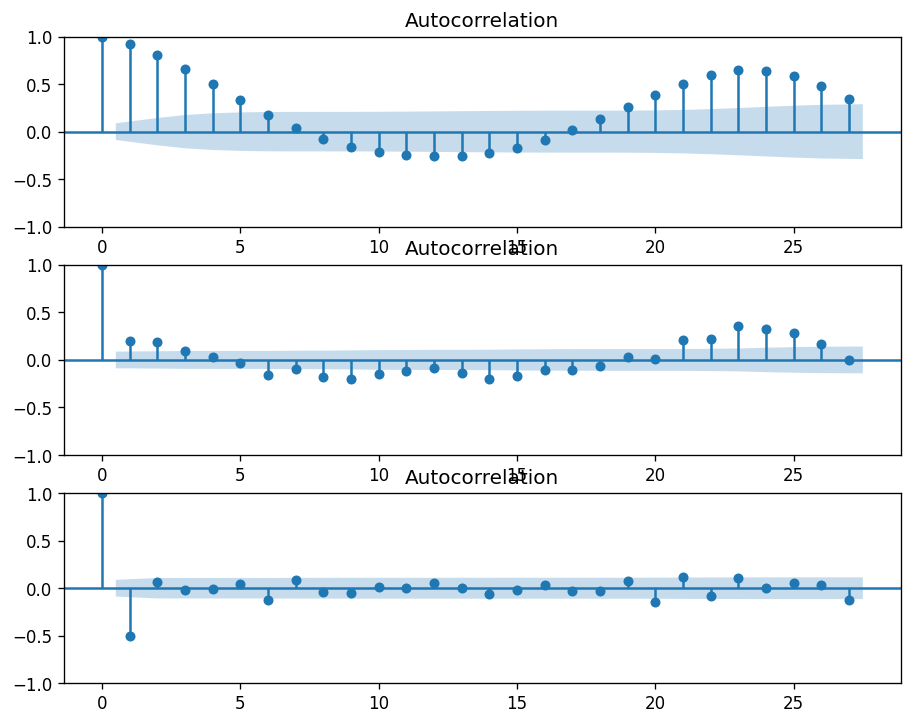

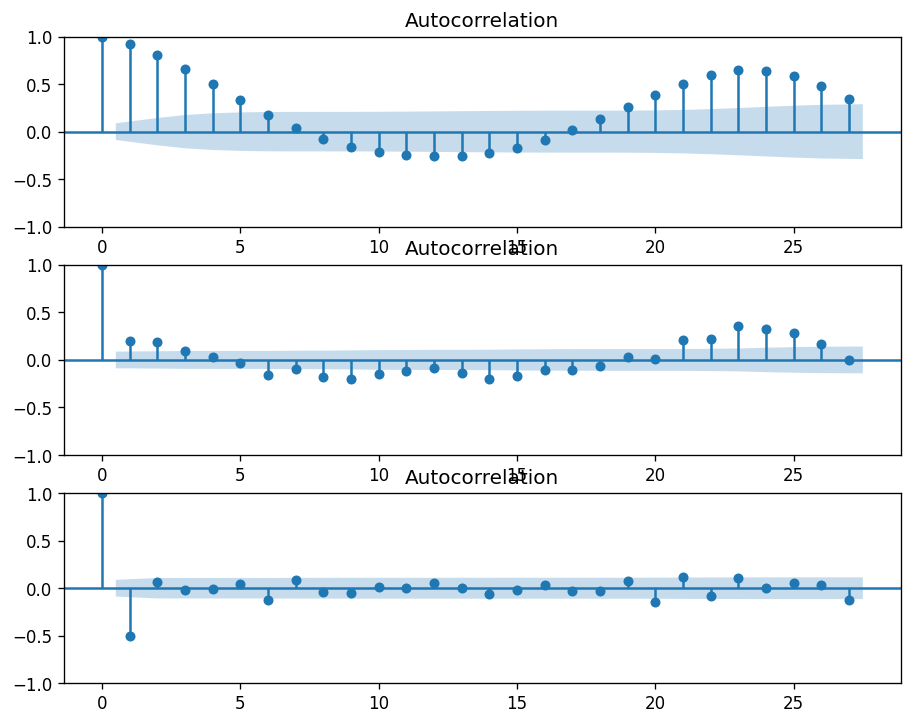

In [10]:
from statsmodels.graphics.tsaplots import plot_acf

# Titta på vart lag för de första värdena i autocorrelation går över till negativa värden!! Verifierar föregående plot 
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(df, ax=ax1)
plot_acf(df.diff().dropna(), ax=ax2)
plot_acf(df.diff().diff().dropna(), ax=ax3)

#acf_diff = plot_acf(df_train_diff)
#pacf_diff = plot_pacf(df_train_diff)

#adf_test =adfuller(df_train_diff)
#print(f'p-value: {adf_test[1]}')
 

PACF plot

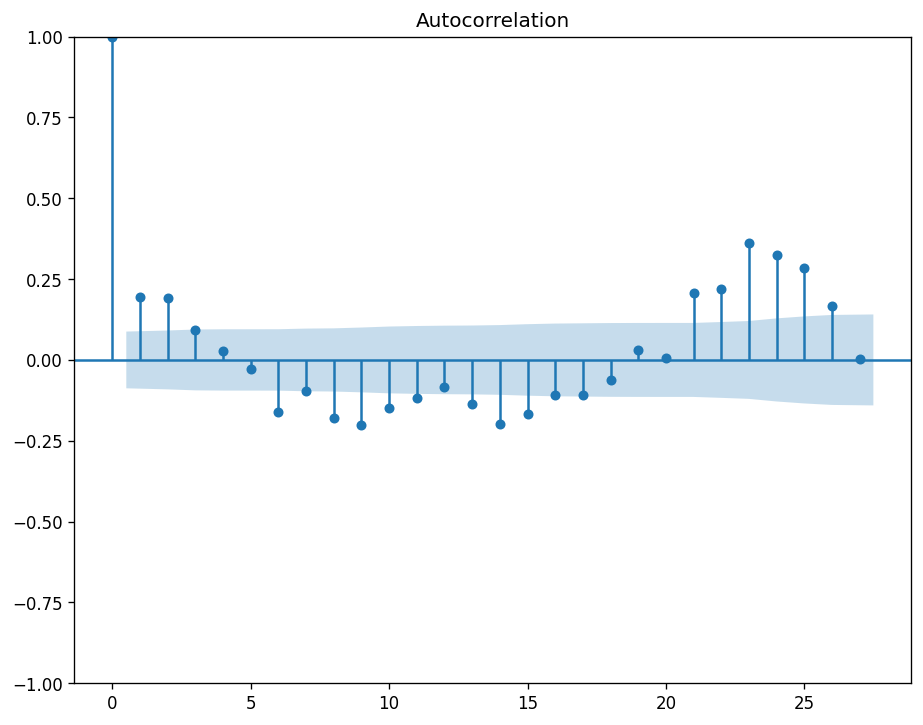

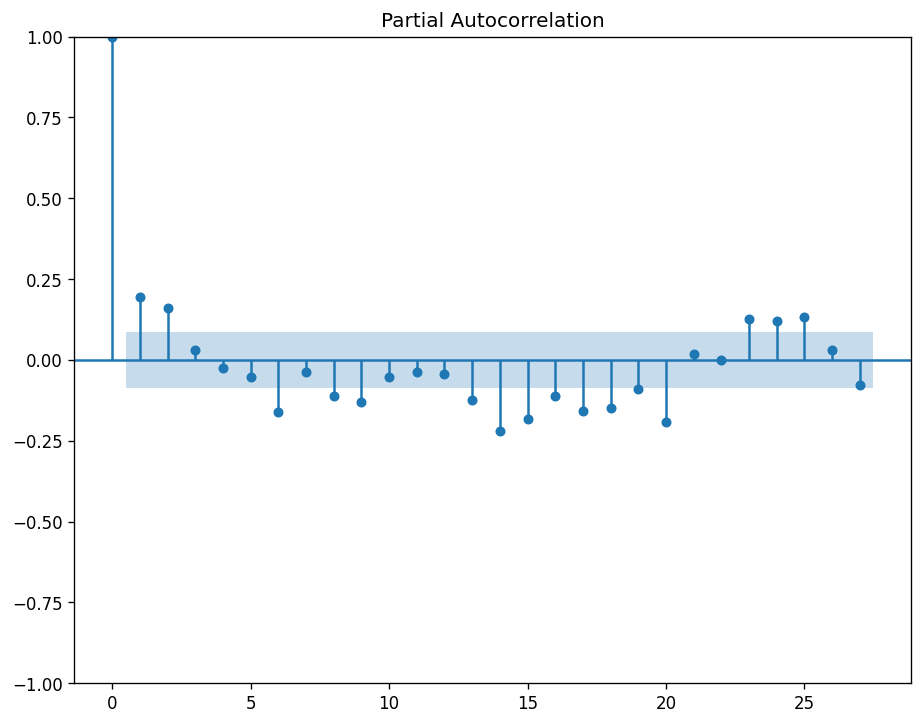

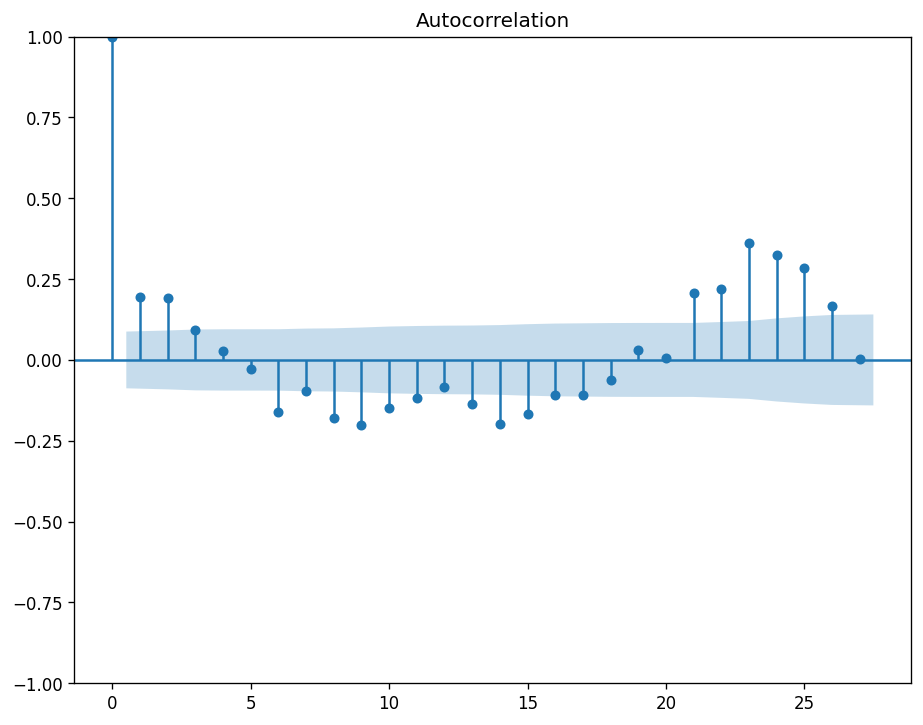

In [11]:
#Here we can see that the first lag is significantly out of the limit 
# and the second one is also out of the significant limit but it is not that far so we can select the order of the p as 1

plot_pacf(df.diff().dropna())

# för att välja värde q kan man undersöka hur många lags som är utanför significance limit 
plot_acf(df.diff().dropna())


#model = ARIMA(df_train, order =(1,2,3)) #detta är parametrarna på p, d, q och iom att p-värder blev noll och pcaf och acf är typ lika provar jag att testa olika här 
#model_fit = model.fit()
#print(model_fit.summary())

In [12]:
import pmdarima as pm
auto_arima = pm.auto_arima(df, stepwise = False, seasonal = False)
auto_arima

ARIMA(order=(3, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [13]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train, order = (3,0,2))
model_fit_1 = model.fit()

print(model_fit_1.summary())

forecast_test = model_fit_1.forecast(len(df_test))

df['forecast_manual'] = [None]*len(df_train) + list(forecast_test)

df.plot()

                               SARIMAX Results                                
Dep. Variable:             total_load   No. Observations:                  322
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -2576.832
Date:                Fri, 05 Apr 2024   AIC                           5167.663
Time:                        10:38:59   BIC                           5194.085
Sample:                    07-01-1995   HQIC                          5178.212
                         - 07-14-1995                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3225.3495    403.724      7.989      0.000    2434.065    4016.634
ar.L1          1.2762      1.959      0.652      0.515      -2.563       5.115
ar.L2         -0.0783      3.332     -0.023      0.9

ValueError: Length of values (503) does not match length of index (500)

In [64]:
#forecast_test = model_fit.forecast(len(df))

#df['forecast_manual'] = [None]*len(df) + list(forecast_test)

#df.plot()

ValueError: Length of values (1440) does not match length of index (720)

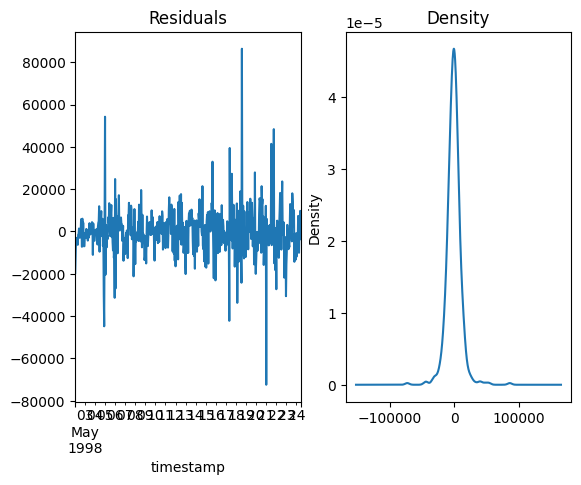

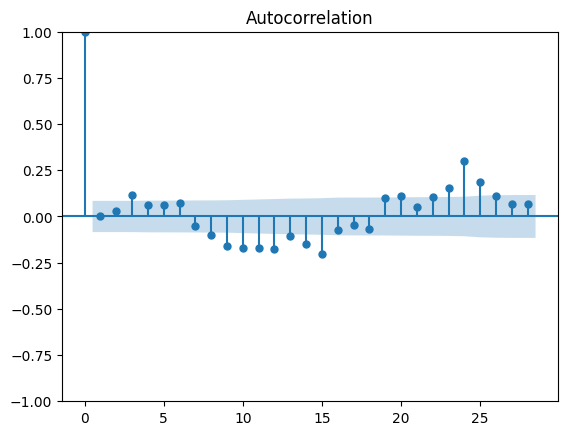

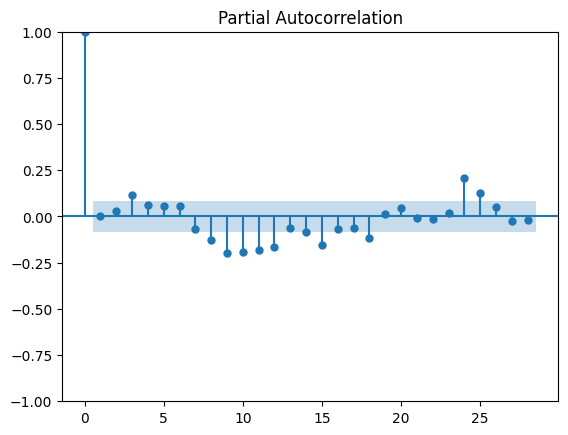

In [33]:
import matplotlib.pyplot as plt 

residuals = model_fit.resid[1:]
fig, ax = plt.subplots (1,2)
residuals.plot(title = "Residuals", ax = ax[0])
residuals.plot(title = "Density", kind ="kde", ax = ax[1])
plt.show()
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals) 

<Axes: xlabel='timestamp'>

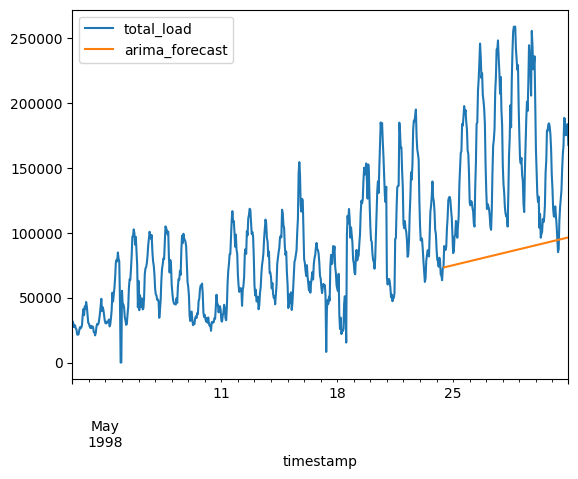

In [34]:
#forecast_test = model_fit.forecast(len(df_test))

#df['arima_forecast'] = [None]*len(df_train) + list(forecast_test)

#df.plot()

adf test bigger than 0.05
                               SARIMAX Results                                
Dep. Variable:             total_load   No. Observations:                  538
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -5769.508
Date:                Mon, 11 Mar 2024   AIC                          11551.016
Time:                        11:00:55   BIC                          11576.732
Sample:                    05-02-1998   HQIC                         11561.076
                         - 05-24-1998                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5208      0.327      1.592      0.111      -0.120       1.162
ar.L2         -0.0491      0.060     -0.818      0.413      -0.167       0.068
ar.L3          0.1185     

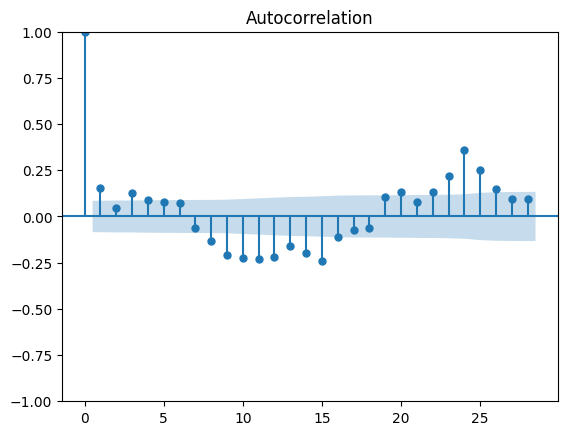

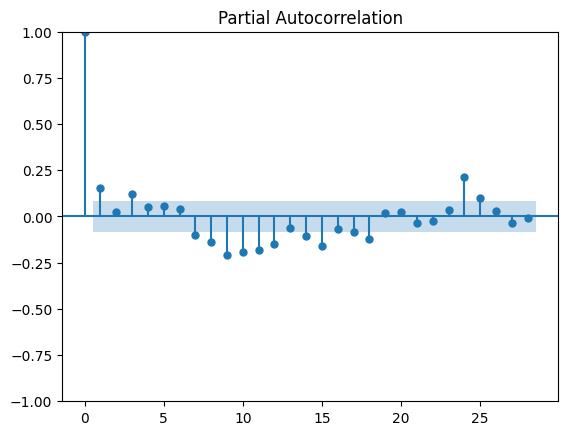

In [19]:
from statsmodels.tsa.arima.model import ARIMA


# Assuming df is your original DataFrame

# Specify the number of periods to forecast
num_periods = len(df_test)

# Create training and test sets
df_train = df.iloc[:-num_periods].copy()
df_test = df.iloc[-num_periods:].copy()


if adf_test[1] > 0.05:
    print("adf test bigger than 0.05")
    df_train_diff = df_train.diff().dropna()
    df_train = df_train_diff

# Plot ACF and PACF
acf_original = plot_acf(df_train)
pacf_original = plot_pacf(df_train)

# Fit ARIMA model
model = ARIMA(df_train, order=(3, 1, 2))
model_fit = model.fit()

# Display model summary
print(model_fit.summary())

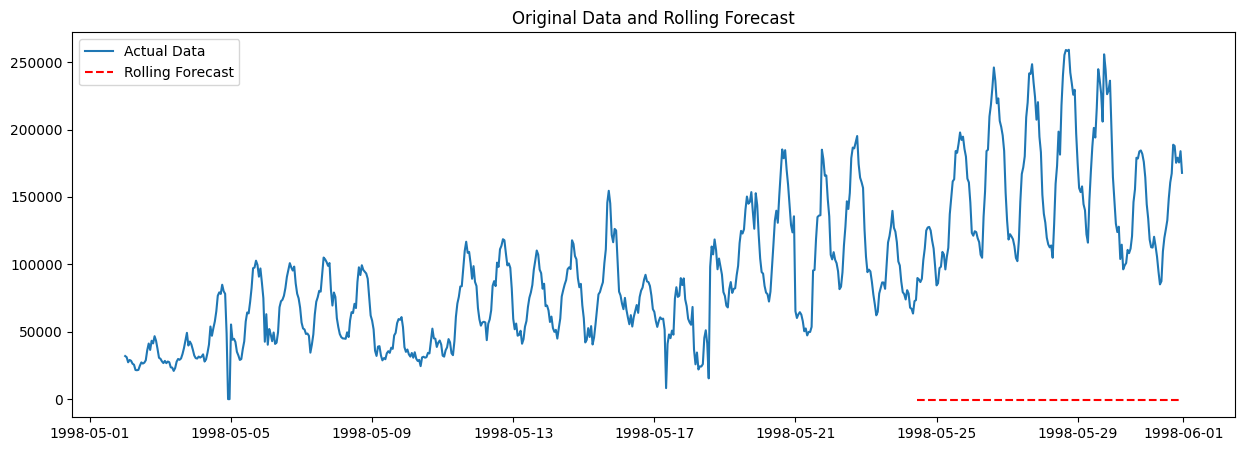

In [12]:
# Initialize an empty column for forecasts
import matplotlib.pyplot as plt
df['forecast_manual'] = [None] * len(df)

# Make rolling forecasts
for i in range(num_periods):
    model_fit = ARIMA(df_train[:len(df_train) + i], order=(3, 1, 2)).fit()
    forecast_value = model_fit.forecast(steps=1)
    df['forecast_manual'].iloc[-num_periods + i] = forecast_value

# Plot the original data and forecasts
plt.figure(figsize=(15, 5))
plt.plot(df['total_load'], label='Actual Data')
plt.plot(df['forecast_manual'], label='Rolling Forecast', linestyle='--', color='red')
plt.legend()
plt.title('Original Data and Rolling Forecast')
plt.show()

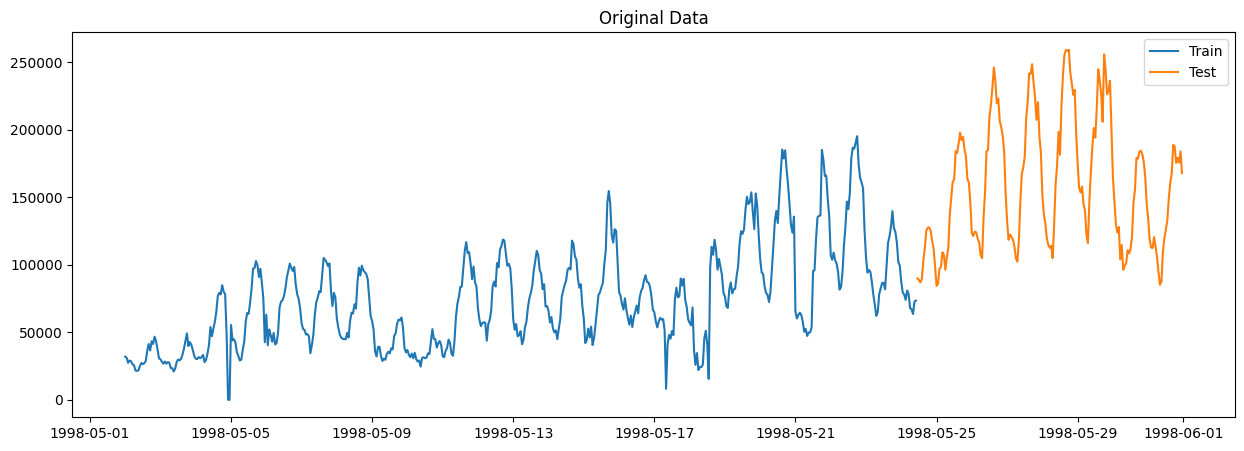

p-value: 0.38474377840081986


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

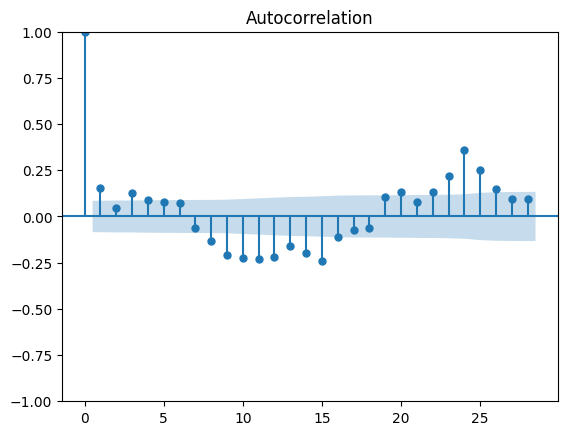

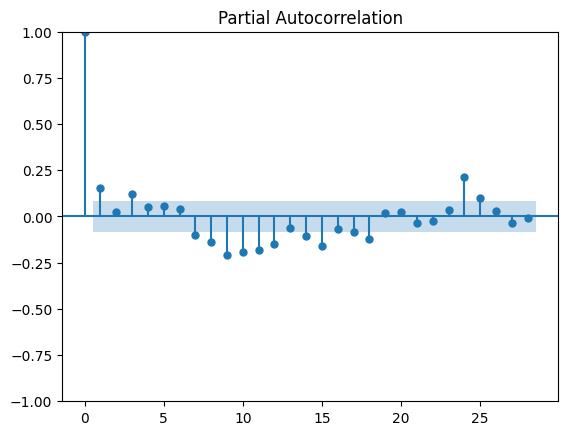

In [49]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Assuming df is your original DataFrame

# Specify the number of periods to forecast
num_periods = len(df_test)

# Create training and test sets
df_train = df.iloc[:-num_periods].copy()
df_test = df.iloc[-num_periods:].copy()

# Plot the training and test sets
plt.figure(figsize=(15, 5))
plt.plot(df_train, label='Train')
plt.plot(df_test, label='Test')
plt.legend()
plt.title('Original Data')
plt.show()

# Check stationarity
adf_test = adfuller(df_train)
print(f'p-value: {adf_test[1]}')

# Difference the training data if necessary
if adf_test[1] > 0.05:
    df_train_diff = df_train.diff().dropna()
    df_train = df_train_diff

# Plot ACF and PACF
acf_original = plot_acf(df_train)
pacf_original = plot_pacf(df_train)

# Initialize an empty column for forecasts
df['forecast_manual'] = [None] * len(df)

# Make rolling forecasts
for i in range(num_periods):
    model_fit = ARIMA(df_train, order=(3, 1, 2)).fit()
    forecast_value = model_fit.forecast(steps=1).values[0]
    df['forecast_manual'].iloc[-num_periods + i] = forecast_value

    # Update the training data for the next iteration
    df_train = df.iloc[:-num_periods + i + 1].copy()

# Plot the original data and forecasts
plt.figure(figsize=(15, 5))
plt.plot(df['data_load'], label='Actual Data')
plt.plot(df['forecast_manual'], label='Rolling Forecast', linestyle='--', color='red')
plt.legend()
plt.title('Original Data and Rolling Forecast')
plt.show()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

Test RMSE: 13015.399


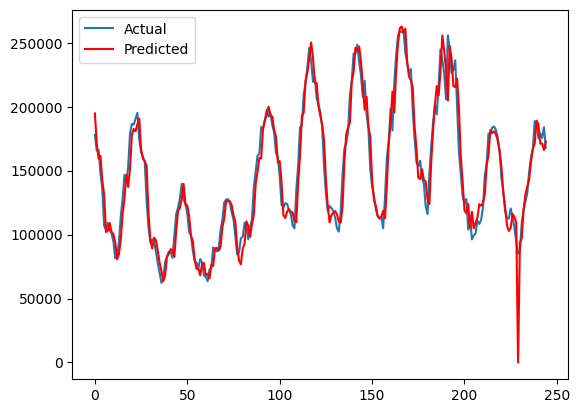

In [63]:
#from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
from matplotlib import pyplot

# Assuming your DataFrame is named 'df' with columns 'timestamp' and 'total_load'
#df['timestamp'] = pd.to_datetime(df['timestamp'])
#df.set_index('timestamp', inplace=True)
#df.index = df.index.to_period('M')

# split into train and test sets
X = df['total_load'].values
size = int(len(X) * 0.66)
df_train, df_test = X[0:size], X[size:len(X)]
history = [x for x in df_train]
predictions = list()

# walk-forward validation
for t in range(len(df_test)):
    model = ARIMA(history, order=(3, 1, 2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = df_test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

# evaluate forecasts
rmse = sqrt(mean_squared_error(df_test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
pyplot.plot(df_test, label='Actual')
pyplot.plot(predictions, color='red', label='Predicted')
pyplot.legend()
pyplot.show()

import numpy as np

In [21]:
import numpy as np
import pandas as pd
import requests
from numpy import mean
from numpy import std

import warnings
warnings.filterwarnings("ignore")
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf




AttributeError: partially initialized module 'pandas' has no attribute '_pandas_parser_CAPI' (most likely due to a circular import)

In [ ]:


##Access Target_device data
QuerytoolBASE = "http://127.0.0.1:5000/"
response = requests.get(QuerytoolBASE+"databaseservice",json={"start_date": "1995", "databasename": "clarknet_full"})
data_result = response.json()
print("helloworl")

#historical_df = pd.DataFrame(data_result, columns=['timestamp', 'average_load', 'total_load', 'instances'])
historical_df = pd.DataFrame(data_result, columns=['timestamp','requests'])

historical_df['timestamp'] = pd.to_datetime(historical_df['timestamp'],format='%a, %d %b %Y %H:%M:%S GMT') 
historical_df['total_load'] = historical_df['requests'].astype(int)
historical_df = historical_df.set_index("timestamp")
historical_df = historical_df.sort_index()
#historical_df =historical_df.drop(columns=[ 'average_load', 'instances'])
historical_df =historical_df.drop(columns=['requests'])
historical_df.plot()
historical_df.head()

In [63]:
historical_df.head()

,total_load
timestamp,
1995-07-01 00:00:01,1
1995-07-01 00:00:06,1
1995-07-01 00:00:09,1
1995-07-01 00:00:11,2
1995-07-01 00:00:12,3


In [170]:
import pmdarima as pm
auto_arima = pm.auto_arima(historical_df, stepwise = False, seasonal = False)
auto_arima

ARIMA(order=(2, 1, 3), scoring_args={}, suppress_warnings=True)

Test RMSE: 475.449


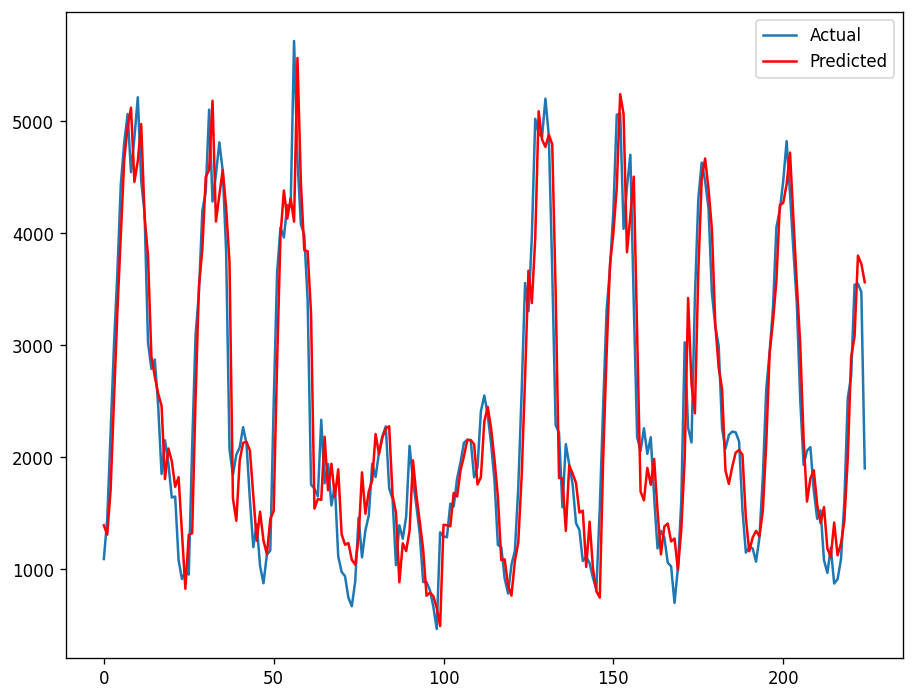

In [171]:
#from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
from matplotlib import pyplot

# Assuming your DataFrame is named 'df' with columns 'timestamp' and 'total_load'
#df['timestamp'] = pd.to_datetime(df['timestamp'])
#df.set_index('timestamp', inplace=True)
#df.index = df.index.to_period('M')

# split into train and test sets
X = historical_df['total_load'].values
size = int(len(X) * 0.66)
df_train, df_test = X[0:size], X[size:len(X)]
history = [x for x in df_train]
predictions = list()

# walk-forward validation
for t in range(len(df_test)):
    model = ARIMA(history, order=(2, 1, 3))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = df_test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

# evaluate forecasts
rmse = sqrt(mean_squared_error(df_test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
pyplot.plot(df_test, label='Actual')
pyplot.plot(predictions, color='red', label='Predicted')
pyplot.legend()
pyplot.show()


LSTM

In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

historical_df.head()
result = seasonal_decompose(historical_df, model='additive', period=1)
result.plot()
pyplot.show()

KeyboardInterrupt: 

In [2]:
len(historical_df)

NameError: name 'historical_df' is not defined

In [95]:
train = historical_df.iloc[:720558]
test = historical_df.iloc[720558:]

In [87]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

historical_df.head(), historical_df.tail()

(                     total_load
 timestamp                      
 1995-07-01 00:00:01           1
 1995-07-01 00:00:06           1
 1995-07-01 00:00:09           1
 1995-07-01 00:00:11           2
 1995-07-01 00:00:12           3,
                      total_load
 timestamp                      
 1995-07-28 13:32:20           4
 1995-07-28 13:32:21           3
 1995-07-28 13:32:22           5
 1995-07-28 13:32:23           3
 1995-07-28 13:32:25           1)

In [89]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [90]:
scaled_train[:10]

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.05263158],
       [0.10526316],
       [0.05263158],
       [0.10526316],
       [0.10526316],
       [0.05263158],
       [0.        ]])

In [91]:
from keras.preprocessing.sequence import TimeseriesGenerator

ModuleNotFoundError: No module named 'tensorflow'